## TEST SET
Applying quickly all the transfomations made in the previous notebook. Just run it and continue to NOTEBOOK 3

### Loading libraries

In [7]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.10f}'.format

### MISSING VALUE VISUALIZATION
import missingno as msno

### DATA PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns

### DATA PREPROCESSING
from functions import *

### IMPUTATION
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

### ENCODING
from sklearn.preprocessing import LabelEncoder

#### Loading data

In [8]:
test = pd.read_csv('../datasets/henry_lab_disk/properties_colombia_test.csv', sep = ',')
test.drop('id', axis=1, inplace=True)
test.rename(columns={'Unnamed: 0':'id'}, inplace=True)
test.set_index('id', inplace=True)

In [9]:
test.shape

(65850, 24)

In [10]:
todrop = ['operation_type', 'currency', 'created_on', 'price_period', 'l1', 'ad_type']
test.drop(todrop, axis=1, inplace=True)
test = trim_all_columns(test)
test['title'] = normalize_column(test, 'title')
test['description'] = normalize_column(test, 'description')
test['title'] = test['title'].str.lower().str.strip()
test['description'] = test['description'].str.lower().str.strip()
pattern = '|'.join(['\n','\r', '\t' ,'\xa0','\u200b',','])
test['title'] = clean_values(test['title'], pattern, value=' ')
test['description'] = clean_values(test['description'], pattern, value=' ')
pattern2 = '|'.join(['_', '[(|)]', '-',':',';'])
test['title'] = clean_values(test['title'], pattern2, regex = True, value=' ')
test['description'] = clean_values(test['description'], pattern2, regex = True, value=' ')
test['title'] = clean_values(test['title'], r"\<.*?\>", regex = True, value=' ')
test['description'] = clean_values(test['description'], pattern2, regex = True, value=' ')
test['title'] = clean_values(test['title'], r"\{.*?\}", regex = True, value=' ')
test['description'] = clean_values(test['description'], pattern2, regex = True, value=' ')
test['title'] = test['title'].str.replace(' +',' ', regex=True)
test['description'] = test['description'].str.replace(' +',' ', regex = True)

test['description'] = test['description'].str.replace('br / ','',regex = False)
test['description'] = test['description'].str.replace('/b','',regex = False)
test['description'] = test['description'].str.replace(' br ','',regex = False)
test['description'] = test['description'].str.replace(' b ','',regex = False)
test['description'] = test['description'].str.replace('&aacute ','a',regex = False)
test['description'] = test['description'].str.replace('&eacute ','e',regex = False)
test['description'] = test['description'].str.replace('&iacute ','i',regex = False)
test['description'] = test['description'].str.replace('&oacute ','o',regex = False)
test['description'] = test['description'].str.replace('&uacute ','u',regex = False)
test['description'] = test['description'].str.replace('&ntilde ','ñ',regex = False)
test['description'] = test['description'].str.replace('ref#\d+','',regex = True)
test['description'] = test['description'].str.replace('!!!','',regex = False)


regex = r"(\d+\.?\d+(?=m2| m2| mts2| metros cuadrados| mts))"
mask1 = test.loc[:,'title'].str.extract(regex, expand = False).notna()
mask2 = test.loc[:,'description'].str.extract(regex, expand = False).notna()
mask_na = test['surface_total'].isna()
test.loc[mask_na & mask1, 'surface_total'] = test.loc[mask_na & mask1, 'title'].str.extract(regex, expand = False)
test.loc[mask_na & mask2, 'surface_total'] = test.loc[mask_na & mask2, 'description'].str.extract(regex, expand = False)

mask1 = test['surface_total'].isna()
mask2 = test['surface_covered'].notna()
test.loc[mask1 & mask2,'surface_total'] = test.loc[mask1 & mask2,'surface_covered']

regex = r"(\d+\.?\d+(?=hectareas| hectareas|hectáreas| hectáreas|hectárea| hectárea|hectare| hectare|has| has))"
indexes = test.loc[:,'description'].str.extract(regex, expand = False).dropna().astype(float).sort_values(ascending = False).index.tolist()
test.loc[indexes, 'surface_total'] = test.loc[indexes,'description'].str.extract(regex, expand = False).dropna().astype(float).mul(10000)

test['surface_total'] = pd.to_numeric(test['surface_total'], errors='coerce')

value = '|'.join(['pileta', 'piscina','natatorio'])
test['pileta'] = test['description'].str.contains(value, regex = True, case = False)
test['pileta'].fillna(False, inplace=True)

value = '|'.join(['vigilancia 24', 'porteria 24', 'seguridad 24', 'vigilancia las 24', 'porteria las 24', 'seguridad las 24'])
test['vigilancia'] = test['description'].str.contains(value, regex = True, case = False)
test['vigilancia'].fillna(False, inplace=True)

value = '|'.join(['patio', 'jardin', 'parque'])
test['patio'] = test['description'].str.contains(value, regex = True, case = False)
test['patio'].fillna(False, inplace=True)

value = '|'.join(['garage', 'garaje', 'cochera', 'parquedero'])
test['garage'] = test['description'].str.contains(value, regex = True, case = False)
test['garage'].fillna(False, inplace=True)

value = '|'.join(['balcon', 'balcn', 'valcon'])
test['balcon'] = test['description'].str.contains(value, regex = True, case = False)
test['balcon'].fillna(False, inplace=True)

value = '|'.join(['cancha'])
test['cancha'] = test['description'].str.contains(value, regex = True, case = False)
test['cancha'].fillna(False, inplace=True)

value = '|'.join(['gimnasio', 'gym', 'gim', 'fitnes'])
test['gimnasio'] = test['description'].str.contains(value, regex = True, case = False)
test['gimnasio'].fillna(False, inplace=True)

value = '|'.join(['sauna', 'solarium', 'ducha turca', 'ducha escocesa'])
test['sauna'] = test['description'].str.contains(value, regex = True, case = False)
test['sauna'].fillna(False, inplace=True)

value = '|'.join(['estren'])
test['a_estrenar'] = test['description'].str.contains(value, regex = True, case = False)
test['a_estrenar'].fillna(False, inplace=True)

regex = r"(\d+(?=bano| bano|banio| banio))"
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bathrooms'] = pd.to_numeric(test['bathrooms'], errors = 'coerce')
test['bathrooms_cat'] = pd.cut(test['bathrooms'], bins = [0,1,2,3,np.inf], labels = ['0','1','2','3 o mas'])

regex = r'(\d+(?=habitac| habitac |alcob| alcob|cuart| cuart))'
mask = test.loc[:,'bedrooms'].isna()
test.loc[mask, 'bedrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bedrooms'] = pd.to_numeric(test['bedrooms'], errors = 'coerce')
test['bedrooms_cat'] = pd.cut(test['bedrooms'], bins = [0,1,2,3,np.inf], labels = ['0','1','2','3 o mas'])

test['description'].fillna(' ', inplace=True)
from spacy.matcher import Matcher
import spacy
nlp = spacy.load('es_core_news_lg')

match_banios = ['bano','banos','banios','banio','baño','baños','baos','bao','sanitario','sanitarios']

matcher_banios = Matcher(nlp.vocab)

# Add the pattern to the matcher
pattern_banios = [
    {'LIKE_NUM': True},
    {'IS_ALPHA': True, 'TEXT':{'IN':match_banios}}
]

matcher_banios.add('X_banios', [pattern_banios])

lista_banios_final = []

In [11]:
for i in range(test.shape[0]):
    text = test.iloc[i,test.columns.get_loc('description')]
    doc = nlp(text)
    matches_banios = matcher_banios(doc) #Gives you and index unique ID, start and end of the match
    lista_banios = []
    if matches_banios != []:
        for match_id, start, end in matches_banios:
            # Get the matched span
            matched_span = doc[start:end]
            lista_banios.append(matched_span.text)
    else:
        lista_banios.append('99')
    lista_banios_final.append(lista_banios)

import re

lista_clean = []

for sublist in lista_banios_final:
    for item in sublist:
        item = re.sub('uno', '1', item)
        item = re.sub('un', '1', item)
        item = re.sub('dos', '2', item)
        item = re.sub('tres', '3', item)
        item = re.sub('cuatro', '4', item)
        item = re.sub('cinco', '5', item)
        item = re.sub('seis', '6', item)
        item = re.sub('siete', '7', item)
        item = re.sub('ocho', '8', item)
        item = re.sub('nueve', '9', item)
        item = re.sub('diez', '10', item)
        lista = re.findall(r'\d+', item)
        lista = [int(x) for x in lista]
        lista_clean.append(sum(lista))

df_banios = pd.DataFrame(lista_clean, columns = ['bathrooms_2'])

df_banios['bathrooms_2'] = df_banios['bathrooms_2'].apply(lambda x: x if x <11 else np.nan)

test = test.merge(df_banios, left_index = True, right_index = True)


from spacy.matcher import Matcher
import spacy
nlp = spacy.load('es_core_news_lg')

list_match_dorm = ['alcoba','alcobas','dormitorios','habitaciones','dormitorio','pieza',
'habitacion','cuarto','cuartos','piezas','habitac','dorms','habitcs']

matcher_dorm = Matcher(nlp.vocab)

# Add the pattern to the matcher
pattern_dorm = [
    {'LIKE_NUM': True},
    {'IS_ALPHA': True, 'TEXT':{'IN':list_match_dorm}}
]

matcher_dorm.add('X_dorm', [pattern_dorm])

lista_dorm_final = []

for i in range(test.shape[0]):
    text = test.iloc[i,test.columns.get_loc('description')]
    doc = nlp(text)
    matches_dorm = matcher_dorm(doc) #Gives you and index unique ID, start and end of the match
    lista_dorm = []
    if matches_dorm != []:
        for match_id, start, end in matches_dorm:
            # Get the matched span
            matched_span = doc[start:end]
            lista_dorm.append(matched_span.text)
    else:
        lista_dorm.append('99')
    lista_dorm_final.append(lista_dorm)


import re

lista_clean_2 = []

for sublist in lista_dorm_final:
    for item in sublist:
        item = re.sub('uno', '1', item)
        item = re.sub('un', '1', item)
        item = re.sub('dos', '2', item)
        item = re.sub('tres', '3', item)
        item = re.sub('cuatro', '4', item)
        item = re.sub('cinco', '5', item)
        item = re.sub('seis', '6', item)
        item = re.sub('siete', '7', item)
        item = re.sub('ocho', '8', item)
        item = re.sub('nueve', '9', item)
        item = re.sub('diez', '10', item)
        lista = re.findall(r'\d+', item)
        lista = [int(x) for x in lista]
        lista_clean_2.append(sum(lista))


df_dorm = pd.DataFrame(lista_clean, columns = ['bedrooms_2'])
print(df_dorm['bedrooms_2'].apply(lambda x: x if x <11 else np.nan).isna().value_counts())
df_dorm['bedrooms_2'].apply(lambda x: x if x <11 else np.nan)


test = test.merge(df_dorm, left_index = True, right_index = True)




test.drop('geometry', axis = 1, inplace = True)
mask_l2 = test.loc[:,'l2'].notna()
mask_l3 = test.loc[:,'l3'].notna()
mask_l4 = test.loc[:,'l4'].notna()
mask_l5 = test.loc[:,'l5'].notna()
mask_l6 = test.loc[:,'l6'].notna()
mask_lat = test.loc[:,'lat'].isna()
mask_lon = test.loc[:,'lon'].isna()

locations_gps = pd.read_csv('./data/gps/locations_all_df_google.csv')
test['full_location'] = test.agg(lambda x: f"{x['l6']},{x['l5']},{x['l4']},{x['l3']},{x['l2']},Colombia", axis=1)
test['full_location'] = test['full_location'].str.replace('nan,','')
test = test.merge(locations_gps, how='left',  left_on='full_location', right_on='l_all', suffixes=('', '_new'))
test['lat'] = np.where(test['lat'].isna(), test['lat_new'], test['lat'])
test['lon'] = np.where(test['lon'].isna(), test['lon_new'], test['lon'])
todrop = ['full_location', 'l_all', 'lat_new', 'lon_new']
test.drop(todrop, axis = 1, inplace = True)

test['end_date'] = pd.to_datetime(test['end_date'], errors = 'coerce')
test['start_date'] = pd.to_datetime(test['start_date'], errors = 'coerce')
test['days_published'] = test['end_date'] - test['start_date']
test['days_published'] = test['days_published'].dt.days
test.drop('end_date', axis = 1, inplace = True)


True     36485
False    31754
Name: bedrooms_2, dtype: int64


In [12]:

todrop = ['bedrooms', 'rooms', 'bathrooms','surface_covered', 'l4', 'l5', 'l6', 'title', 'description',
 'bathrooms_cat',
 'bedrooms_cat']

test_before_drop = test.copy()
test.drop(todrop, axis = 1, inplace = True)

test['l2'].fillna('NA', inplace = True)
test['l3'].fillna('NA', inplace = True)
test['property_type'].fillna(test['property_type'].mode()[0], inplace = True)

cat_encode = [
 'pileta',
 'vigilancia',
 'patio',
 'garage',
 'balcon',
 'cancha',
 'gimnasio',
 'sauna',
 'a_estrenar']#,
 #'bathrooms_cat',
 #'bedrooms_cat']

le = LabelEncoder()
test[cat_encode] = test[cat_encode].apply(lambda x: le.fit_transform(x))

test['surface_total'] = test['surface_total'].astype(float)
test['start_date'].fillna(test['start_date'].mode()[0], inplace = True)

lista_na = test.loc[:, test.isna().any()].columns.tolist()
test_mice = test.filter(lista_na, axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(test_mice), columns=test_mice.columns)
test[df_mice_imputed.columns.tolist()] = df_mice_imputed

In [13]:
test.shape

(3073, 19)

In [14]:
test.to_csv('./data/cleaned/test_cleaned_imputed.csv', index = True)

In [15]:
from pandas_profiling import ProfileReport
profile = ProfileReport(test)
profile.to_file("reporte_test.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## MINIMAL EXPLORATORY ANALYSIS

## CORRELATION PLOT

<AxesSubplot:>

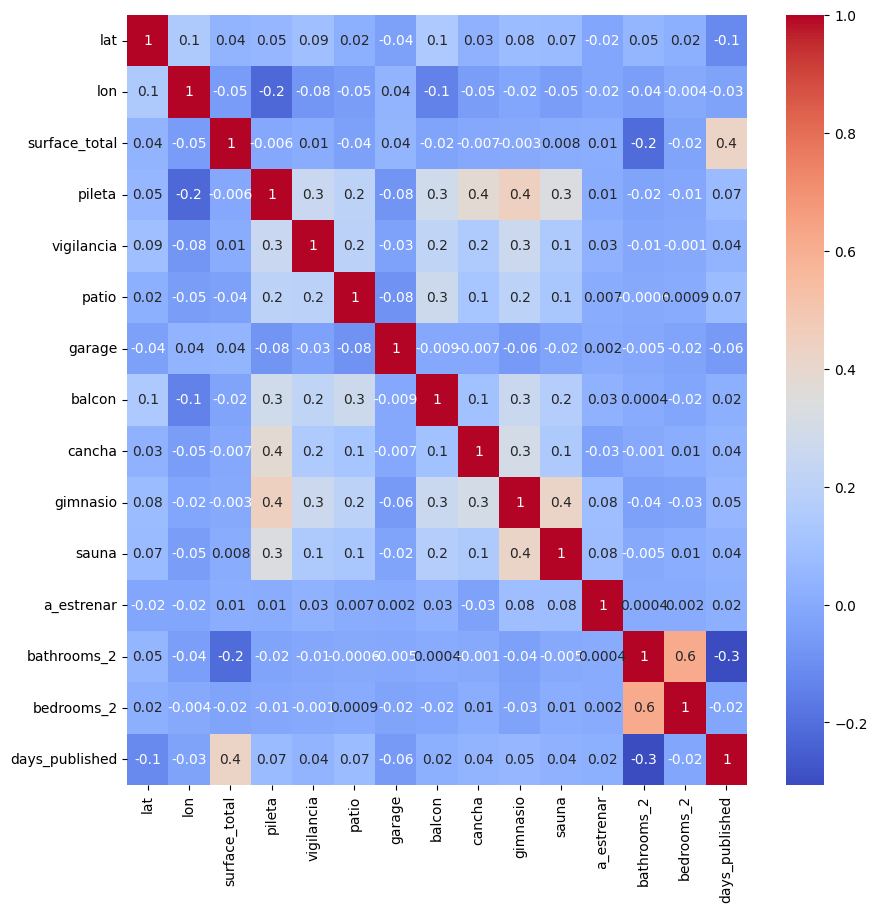

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(test.corr(method='spearman'), annot=True, fmt='.1g', cmap='coolwarm')

In [17]:
test.describe()

,lat,lon,surface_total,pileta,vigilancia,patio,garage,balcon,cancha,gimnasio,sauna,a_estrenar,bathrooms_2,bedrooms_2,days_published
count,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000,3073.0000000000
mean,5.4946738535,-75.1556227109,45717.1961799410,0.2017572405,0.1295151318,0.5743573056,0.1958997722,0.2590302636,0.0953465669,0.1269118126,0.0520663846,0.0475105760,2.2755761024,53.8008460788,37.8969561317
std,1.6744639085,0.9319311344,276439.0752222449,0.4013772315,0.3358238556,0.4945205471,0.3969563307,0.4381735552,0.2937408331,0.3329283313,0.2221970802,0.2127629010,0.7922410251,48.2732433956,55.7161193530
min,1.2027944800,-77.2989042478,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
25%,4.7110000000,-75.5790000000,1200.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2.0000000000,2.0000000000,1.0000000000
50%,5.0571739100,-75.5151088000,45717.1662997477,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2.2699186872,99.0000000000,12.0000000000
75%,6.2476376000,-74.1692406000,45717.1961324877,0.0000000000,0.0000000000,1.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2.3050518406,99.0000000000,59.0000000000
max,11.2672111700,-72.3740000000,9280000.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,10.0000000000,99.0000000000,368.0000000000


In [18]:
cat = ['property_type','pileta','vigilancia','patio','garage','balcon','cancha','gimnasio','sauna','a_estrenar']#,'bathrooms_cat','bedrooms_cat']

subset = test.drop(['l2','l3','start_date','lat','lon'], axis=1)

In [19]:
from tableone import TableOne, load_dataset
#https://tableone.readthedocs.io/en/latest/quickstart.html

mytable = TableOne(subset, dip_test=True, normal_test=True, tukey_test=True, categorical = cat)

mytable.tableone

Missing             Overall
n                                                                3073
surface_total, mean (SD)                        0  45717.2 (276439.1)
property_type, n (%)      Apartamento           0         1442 (46.9)
                          Casa                             925 (30.1)
                          Finca                               6 (0.2)
                          Local comercial                     9 (0.3)
                          Lote                             369 (12.0)
                          Oficina                            16 (0.5)
                          Otro                             306 (10.0)
pileta, n (%)             0                     0         2453 (79.8)
                          1                                620 (20.2)
vigilancia, n (%)         0                     0         2675 (87.0)
                          1                                398 (13.0)
patio, n (%)              0                     0         1308 (42.6)
                          1                               1765 (57.4)
garage, n (%)             0                     0         2471 (80.4)
                          1                                602 (19.6)
balcon, n (%)             0                     0         2277 (74.1)
                          1                                796 (25.9)
cancha, n (%)             0                     0         2780 (90.5)
                          1                                 293 (9.5)
gimnasio, n (%)           0                     0         2683 (87.3)
                          1                                390 (12.7)
sauna, n (%)              0                     0         2913 (94.8)
                          1                                 160 (5.2)
a_estrenar, n (%)         0                     0         2927 (95.2)
                          1                                 146 (4.8)
bathrooms_2, mean (SD)                          0           2.3 (0.8)
bedrooms_2, mean (SD)                           0         53.8 (48.3)
days_published, mean (SD)                       0         37.9 (55.7)